# Imports and loading in cleaned data

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier,XGBRegressor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
df = pd.read_csv('./data/cleaned_data.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45113 entries, 0 to 45112
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                45113 non-null  int64  
 1   Month                     45113 non-null  object 
 2   Age                       45113 non-null  float64
 3   Annual_Income             45113 non-null  float64
 4   Monthly_Inhand_Salary     45113 non-null  float64
 5   Num_Bank_Accounts         45113 non-null  int64  
 6   Num_Credit_Card           45113 non-null  int64  
 7   Interest_Rate             45113 non-null  int64  
 8   Num_of_Loan               45113 non-null  float64
 9   Delay_from_due_date       45113 non-null  int64  
 10  Num_of_Delayed_Payment    45113 non-null  float64
 11  Num_Credit_Inquiries      44239 non-null  float64
 12  Credit_Mix                45113 non-null  object 
 13  Outstanding_Debt          45113 non-null  float64
 14  Credit

In [9]:
df['Credit_Score'].value_counts()

Standard    24916
Poor        13407
Good         6790
Name: Credit_Score, dtype: int64

# Test Train Split 

In [16]:
X = df.drop(['Credit_Score','Unnamed: 0'], axis=1)
y = df['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=.2)

In [17]:
print(X_train.shape, X_test.shape)

(36090, 18) (9023, 18)


In [18]:
X.head()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Monthly_Balance
0,January,23.0,19114.12,1824.843333,3,4,3,4.0,3,7.0,4.0,other,809.98,26.822620,22.0,No,80.415295,312.494089
1,July,23.0,19114.12,1824.843333,3,4,3,4.0,3,8.0,4.0,Good,809.98,22.537593,22.0,No,178.344067,244.565317
2,August,23.0,19114.12,1824.843333,3,4,3,4.0,3,6.0,4.0,Good,809.98,23.933795,NaN,No,24.785217,358.124168
3,January,28.0,34847.84,3037.986667,2,4,6,1.0,3,4.0,2.0,Good,605.03,24.464031,26.0,No,104.291825,470.690627
4,February,28.0,34847.84,3037.986667,2,4,6,1.0,7,1.0,2.0,Good,605.03,38.550848,26.0,No,40.391238,484.591214


# Preprocessing Pipeline

In [19]:
#subpipes that scale numeric data and use one hot encoder on categorical 
subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [20]:
#Create a column transformer to apply the subpipes and transform the data
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
     ('subpipe_cat', subpipe_cat, selector(dtype_include=object))], remainder='passthrough')

# Baseline Dummy Model

In [21]:
#Create a pipeline for dummy model using most_freq strategy
dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

In [22]:
dummy_model_pipe.fit(X_train, y_train)
dummy_model_pipe.score(X_train,y_train)

0.5523690773067331

# Simple Untuned Models Without SMOTE

In [57]:
classifiers = [
    XGBClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    LogisticRegression(random_state=42,max_iter=1000),
    SVC(random_state=42)
     ]

In [58]:
for classifier in classifiers:
    steps = [
        ('ct', CT),
        ('clf', classifier) ]
    pipeline = ImPipeline(steps)
    pipeline.fit(X_train, y_train)   
    print(classifier)
    print("train model score: %.3f" % pipeline.score(X_train, y_train))
    print("test model score: %.3f" % pipeline.score(X_test, y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
train model score: 0.850
test model score: 0.773
DecisionTreeClassifier(random_state=42)
train model score: 1.000
test model score: 0.689
RandomForestClassifier(random_state=42)
train model score: 1.000
test model score: 0.791
LogisticRegression(max_iter=1000, random_state=42)
train model score: 0.662
test model sc

# Simple Untuned Models With SMOTE

In [59]:
for classifier in classifiers:
    steps = [
        ('ct', CT),
        ('sm',SMOTE(random_state=42)),
        ('clf', classifier) ]
    pipeline = ImPipeline(steps)
    pipeline.fit(X_train, y_train)   
    print(classifier)
    print("train model score: %.3f" % pipeline.score(X_train, y_train))
    print("test model score: %.3f" % pipeline.score(X_test, y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
train model score: 0.837
test model score: 0.768
DecisionTreeClassifier(random_state=42)
train model score: 1.000
test model score: 0.677
RandomForestClassifier(random_state=42)
train model score: 1.000
test model score: 0.780
LogisticRegression(max_iter=1000, random_state=42)
train model score: 0.681
test model sc

# GridSearch LogReg Model (Did not perform well after GS)

In [292]:
#LogisticRegression().get_params().keys()

In [293]:
#log_model = ImPipeline(steps=[('CT', CT),
                              #('sm',SMOTE(random_state=42)),
                             #('log', LogisticRegression(random_state=42))])

In [294]:
#parameters = {"log__C": [.1,.01,.001,.0001],
              #"log__solver": ['newton-cg', 'lbfgs', 'liblinear'],
              #"log__multi_class":['auto', 'ovr'],
              #"log__max_iter":[1000]
             #}

In [295]:
#gs_log = GridSearchCV(log_model,parameters, cv=5)

In [296]:
#gs_log.fit(X_train,y_train)

In [297]:
#gs_log.best_params_

In [298]:
#gs_log_model = ImPipeline(steps=[('CT', CT),
                               #('sm',SMOTE(random_state=42)),
                              #('log', LogisticRegression(random_state=42,C=0.1,multi_class='auto',solver='liblinear',max_iter=1000))])

In [299]:
#gs_log_model.fit(X_train,y_train)

In [300]:
#gs_log_model.score(X_train,y_train)

# GridSearch XGB 

In [60]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [23]:
xgb_model = ImPipeline(steps=[('CT', CT),
                              ('sm',SMOTE(random_state=42)),
                              ('xgb', XGBClassifier(random_state=42,max_depth=6))])

In [24]:
param_test1 = {
 'xgb__min_child_weight':[.1,.25,.5,1],
 'xgb__learning_rate':[.01,.1,.25,.5],
 'xgb__reg_alpha':[1e-5, 1e-2, 0.1, 1]
}

In [25]:
gs_xgb = GridSearchCV(estimator = xgb_model, param_grid = param_test1, scoring='accuracy',n_jobs=-1,verbose = 10, cv=3)

gs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 16

[19:13:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000019E17DFB520>),
                                                                        ('subpipe_cat',
                                                                         Pipe

In [26]:
gs_xgb.best_params_

{'xgb__learning_rate': 0.5, 'xgb__min_child_weight': 0.5, 'xgb__reg_alpha': 1}

# First XGB Model

In [27]:
xgb_first_model = ImPipeline(steps=[('CT', CT),
                              ('sm',SMOTE(random_state=42)),
                              ('xgb', XGBClassifier(max_depth=6,min_child_weight=.5,learning_rate=.5,reg_alpha=1,silent=True,verbosity=0))])

In [28]:
xgb_first_model.fit(X_train,y_train)

C:\Users\Kev\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:13:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019E17DFB520>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequen...
                               interaction_constraints='', learning_rate=0.5,
                               max_de

In [29]:
xgb_first_model.score(X_train,y_train)

0.8901080631753948

In [30]:
xgb_first_model.score(X_test,y_test)

0.773467804499612

In [31]:
param_test2 = {
 'xgb__n_estimators':[100,200,300,400]
}
gs_xgb2 = GridSearchCV(estimator = xgb_first_model, param_grid = param_test2,scoring='accuracy',n_jobs=-1,,verbosity=10, cv=3)
gs_xgb2.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   44.5s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   45.7s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  1.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.3min remaining:   39.1s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.6min remaining:   27.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.7min finished
C:\Users\Kev\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when construct

[19:15:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000019E17DFB520>),
                                                                        ('subpipe_cat',
                                                                         Pipe

In [32]:
gs_xgb2.best_params_

{'xgb__n_estimators': 300}

# Second XGB Model 

In [107]:
xgb_second_model = ImPipeline(steps=[('CT', CT),
                              ('sm',SMOTE(random_state=42)),
                              ('xgb', XGBClassifier(
                    max_depth=6,
                    min_child_weight=.1,
                    reg_alpha=1,
                    n_estimators=300,
                    learning_rate=.1,
                    max_delta_step=.07
                              ))])

In [108]:
xgb_second_model.fit(X_train,y_train)


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6DDD527F0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                        

In [109]:
xgb_second_model.score(X_train,y_train)

0.7482128013300083

In [110]:
xgb_second_model.score(X_test,y_test)

0.7345672171118254

# Third XGB Model

In [211]:
xgb_third_model = ImPipeline(steps=[('CT', CT),
                              ('sm',SMOTE(random_state=42)),
                              ('xgb', XGBClassifier(
                    max_depth=6,
                    min_child_weight=.1,
                    reg_alpha=1,
                    n_estimators=300,
                    learning_rate=.095,
                    max_delta_step=.065,
                              ))])

In [212]:
xgb_third_model.fit(X_train,y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6DDD527F0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                        

In [213]:
xgb_third_model.score(X_train,y_train)

0.743086727625381

In [214]:
xgb_third_model.score(X_test,y_test)

0.7326831430787987

# Gridsearch RFC

In [55]:
rfc_model = ImPipeline(steps=[('CT', CT),
                              ('sm',SMOTE(random_state=42)),
                              ('rfc',RandomForestClassifier(random_state=42,min_samples_split=10,min_samples_leaf=2,max_features= 'sqrt',max_depth=12,bootstrap = False,criterion='entropy'))])

In [56]:
#Specified ranges for different parameters
params = {
    "rfc__n_estimators":[5,10,50,100,250,500]}

In [57]:
rfc = GridSearchCV(rfc_model,params,cv=5)
rfc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000019E17DFB520>),
                                                                        ('subpipe_cat',
                                                                         Pipe

In [58]:
rfc.best_params_

{'rfc__n_estimators': 250}

In [59]:
rfc_model = ImPipeline(steps=[('CT', CT),
                              ('sm',SMOTE(random_state=42)),
                                  ('rfc', RandomForestClassifier(n_estimators=250,min_samples_split=10,min_samples_leaf=2,max_features= 'sqrt',max_depth=12,bootstrap = False,criterion='entropy')
)])

In [60]:
rfc_model.fit(X_train,y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019E17DFB520>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [61]:
rfc_model.score(X_train,y_train)

0.7358825159323913

In [62]:
rfc_model.score(X_test,y_test)

0.7176105508145849

# Final Chosen Model XGB

In [23]:
xgb_final_model = ImPipeline(steps=[('CT', CT),
                              ('sm',SMOTE(random_state=42)),
                              ('xgb', XGBClassifier(
                    max_depth=6,
                    min_child_weight=.1,
                    reg_alpha=1,
                    n_estimators=300,
                    learning_rate=.095,
                    max_delta_step=.065,
                              ))])

In [24]:
xgb_final_model.fit(X_train,y_train)

[12:16:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000251E2439760>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                        

In [25]:
xgb_final_model.score(X_train,y_train)

0.743086727625381

In [26]:
xgb_final_model.score(X_test,y_test)

0.7326831430787987

In [255]:
xgb_final_model[2].feature_importances_
feat_import = {name: score 
                   for name, score
                       in zip(X_train.columns, xgb_fourth_model[2].feature_importances_)
}
feat_import

{'Month': 0.0023810389,
 'Age': 0.0018036994,
 'Annual_Income': 0.0020373666,
 'Monthly_Inhand_Salary': 0.0063969707,
 'Num_Bank_Accounts': 0.018373834,
 'Num_Credit_Card': 0.03986589,
 'Interest_Rate': 0.0066248225,
 'Num_of_Loan': 0.015096472,
 'Delay_from_due_date': 0.010709844,
 'Num_of_Delayed_Payment': 0.007881666,
 'Num_Credit_Inquiries': 0.075102225,
 'Credit_Mix': 0.00074885366,
 'Outstanding_Debt': 0.0036000656,
 'Credit_Utilization_Ratio': 0.0037869297,
 'Credit_History_Age': 0.0014980618,
 'Payment_of_Min_Amount': 0.018895984,
 'Amount_invested_monthly': 0.017398344,
 'Monthly_Balance': 0.017211303}

In [261]:
values = []
keys = []
for x in feat_import:
    if feat_import[x] > .01:
        keys.append(x)
        values.append(feat_import[x])

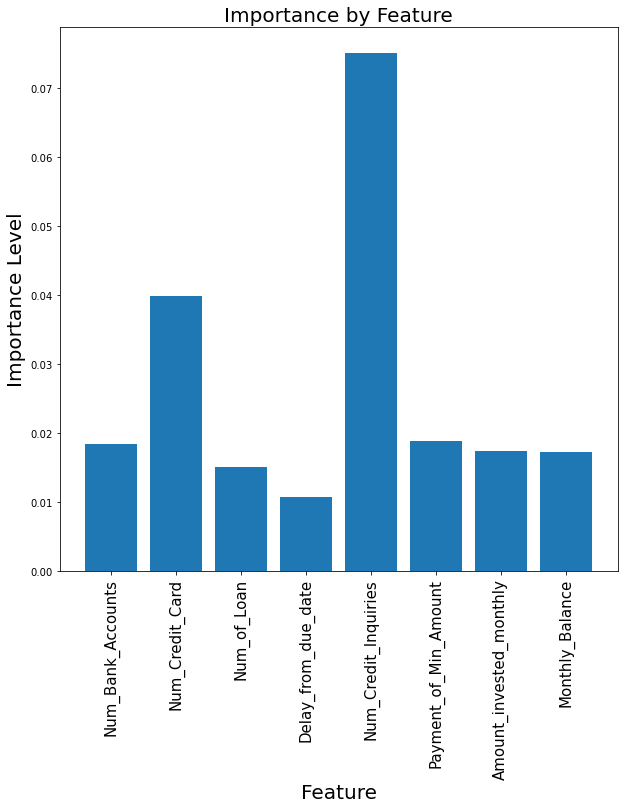

In [263]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(keys,values)

plt.xticks(rotation=90,size=15)
plt.title('Importance by Feature',size=20)
plt.xlabel('Feature',size=20)
plt.ylabel('Importance Level',size=20);

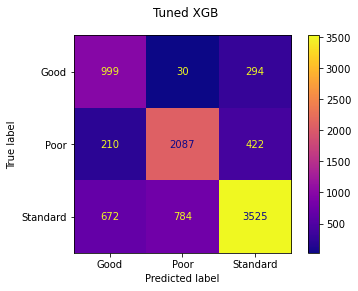

In [310]:
fig, ax = plt.subplots()

fig.suptitle("Tuned XGB")

plot_confusion_matrix(xgb_final_model, X_test, y_test, ax=ax, cmap="plasma");

In [266]:
y_pred = xgb_final_model.predict(X_test)

In [267]:
print("Accuracy Score : ",accuracy_score(y_test, y_pred, 
                                           ))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average='weighted'))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average='weighted'))
print("f1 Score : ",f1_score(y_test, y_pred, 
                                           average='weighted'))

Accuracy Score :  0.7326831430787987
Precision Score :  0.753494518648368
Recall Score :  0.7326831430787987
f1 Score :  0.7372588879905659


In [268]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.53      0.76      0.62      1323
        Poor       0.72      0.77      0.74      2719
    Standard       0.83      0.71      0.76      4981

    accuracy                           0.73      9023
   macro avg       0.69      0.74      0.71      9023
weighted avg       0.75      0.73      0.74      9023



In [27]:
import pickle
pickle.dump(xgb_final_model, open("xgb_final_model.sav", 'wb'))

In [28]:
loaded_model = pickle.load(open("xgb_final_model.sav", 'rb'))

In [29]:
loaded_model.score(X_test, y_test)

0.7326831430787987

In [39]:
X_test.head()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Monthly_Balance
40190,February,53.0,26420.21,2462.684167,8,3,11,1.0,31,12.0,1.0,other,289.24,30.621614,33.0,No,32.294931,449.609436
5245,May,33.0,18827.29,1484.940833,9,6,32,3.0,31,27.0,10.0,Bad,1370.06,27.681395,NaN,Yes,41.890857,342.622035
38919,August,27.0,41848.26,3578.355000,8,7,11,1.0,16,17.0,2.0,Standard,616.98,23.211877,32.0,No,154.123782,431.985973
3401,August,36.0,58537.38,4688.115000,7,5,19,4.0,19,10.0,NaN,other,259.63,24.096692,23.0,No,93.471162,509.487032
20178,April,37.0,59665.20,4870.100000,6,6,15,4.0,48,22.0,10.0,Bad,2288.25,31.330589,9.0,Yes,58.201790,554.841821


In [43]:
X_test[1:2]

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Monthly_Balance
5245,May,33.0,18827.29,1484.940833,9,6,32,3.0,31,27.0,10.0,Bad,1370.06,27.681395,NaN,Yes,41.890857,342.622035


In [47]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9023 entries, 40190 to 31621
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     9023 non-null   object 
 1   Age                       9023 non-null   float64
 2   Annual_Income             9023 non-null   float64
 3   Monthly_Inhand_Salary     9023 non-null   float64
 4   Num_Bank_Accounts         9023 non-null   int64  
 5   Num_Credit_Card           9023 non-null   int64  
 6   Interest_Rate             9023 non-null   int64  
 7   Num_of_Loan               9023 non-null   float64
 8   Delay_from_due_date       9023 non-null   int64  
 9   Num_of_Delayed_Payment    9023 non-null   float64
 10  Num_Credit_Inquiries      8861 non-null   float64
 11  Credit_Mix                9023 non-null   object 
 12  Outstanding_Debt          9023 non-null   float64
 13  Credit_Utilization_Ratio  9023 non-null   float64
 14  Cre

In [49]:
X_test.columns

Index(['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
       'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Payment_of_Min_Amount',
       'Amount_invested_monthly', 'Monthly_Balance'],
      dtype='object')

In [44]:
y_test[1:2]

5245    Poor
Name: Credit_Score, dtype: object

In [45]:
loaded_model.predict(X_test[1:2])

array(['Poor'], dtype=object)

In [56]:
used_columns = ['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
       'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Payment_of_Min_Amount',
       'Amount_invested_monthly', 'Monthly_Balance']

In [62]:
example_row = ['May',27.0,35000.26,2000.26,8,5,35,4.0,30,25.0,12.0,'Bad',1635.05,24.22,5.0,'Yes',55.62,380.4]

In [60]:
len(example_row)

17

In [61]:
len(used_columns)

18

In [63]:
new_test_sample = pd.DataFrame(dict(zip(used_columns,example_row)),index=[0])

In [64]:
loaded_model.predict(new_test_sample)

array(['Poor'], dtype=object)

In [65]:
loaded_model.predict_proba(new_test_sample)

array([[0.0277726 , 0.8264958 , 0.14573158]], dtype=float32)